In [2]:
import pandas as pd
import numpy as np
import statistics

# this code calls tensorflow 1 compatibility
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import seaborn as sns
import DeepAE as DAE
import l21shrink as SHR  # also changing to l1 to access function
import xlrd
from robust_deep_autoencoders import RDAE
import numpy.linalg as nplin
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


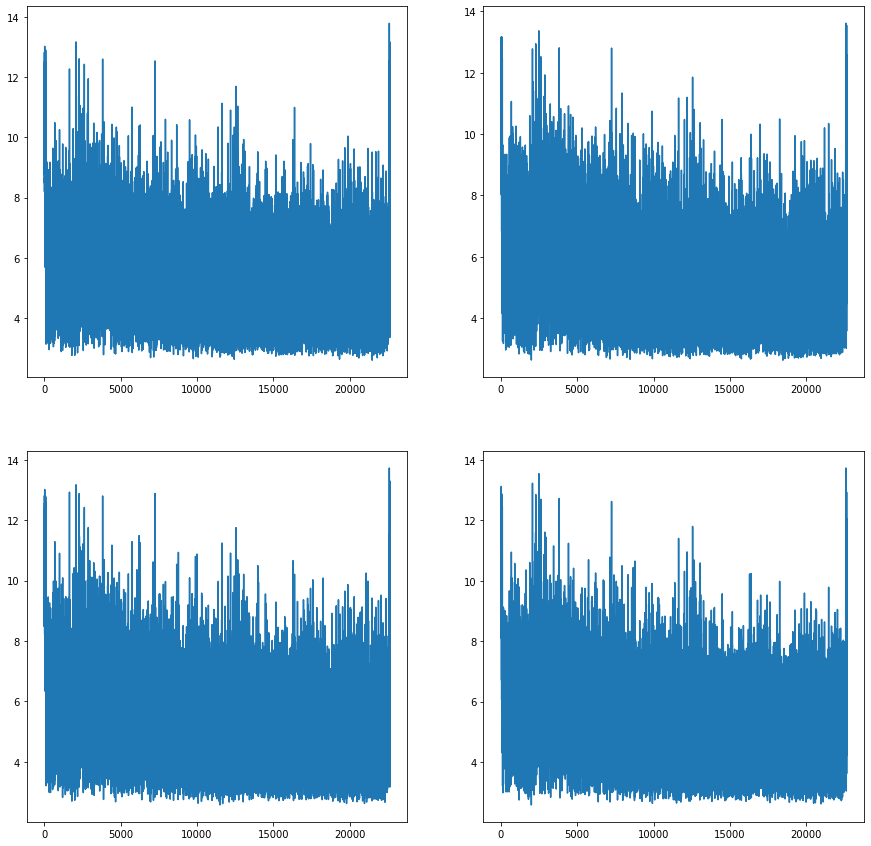

In [42]:
df = pd.read_csv("Leukemia_GSE22529_U133B.csv")
X = df.iloc[:,2:].to_numpy()


fig, axs = plt.subplots(2,2,figsize=(15,15))
count = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].plot(X[count])
        count += 1

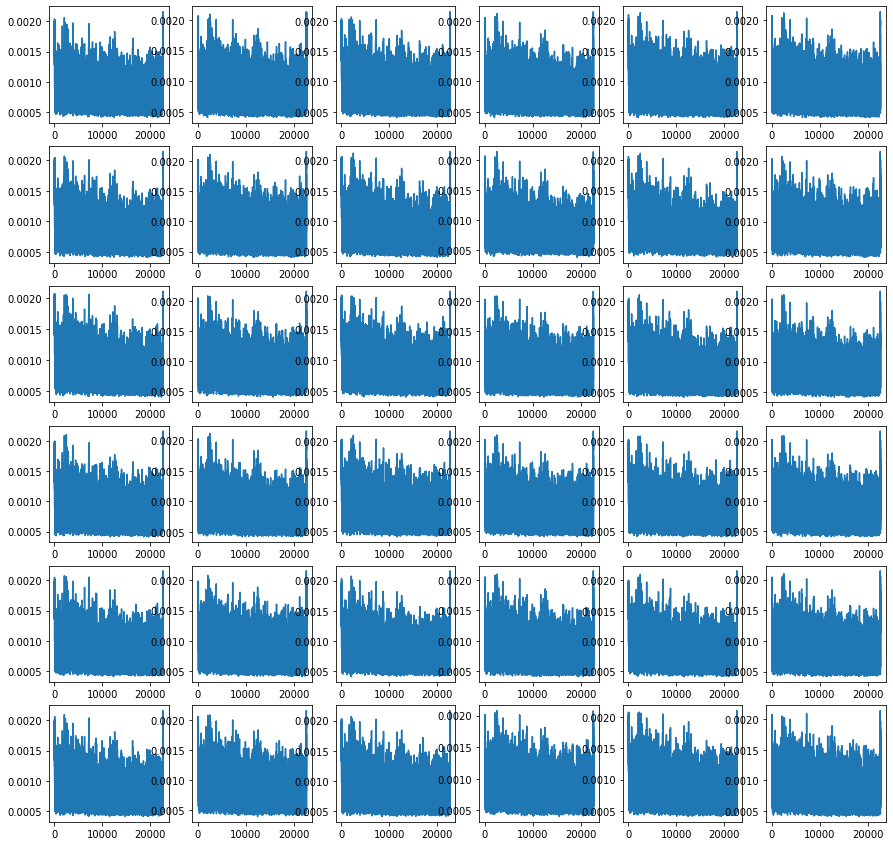

In [43]:
#Normalize
X = X/np.linalg.norm(X)
fig, axs = plt.subplots(6,6,figsize=(15,15))
count = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].plot(X[count])
        count += 1

X = np.matrix(X)
m,n = X.shape

In [ ]:
with tf.Session() as sess:
    layers = [n, int(n * 0.5)]
    rae = RDAE(sess=sess, lambda_=5000, layers_sizes=layers)
    # rae = RDAE(sess=sess, lambda_=2000, layers_sizes=[784, 400])

    L, S = rae.fit(X, sess=sess, learning_rate=0.01, batch_size=5, inner_iteration=10,
                   iteration=2, verbose=True)

    l21R = rae.getRecon(X, sess=sess)
    l21H = rae.transform(X, sess)

    print("cost errors, not used for now:", rae.errors)

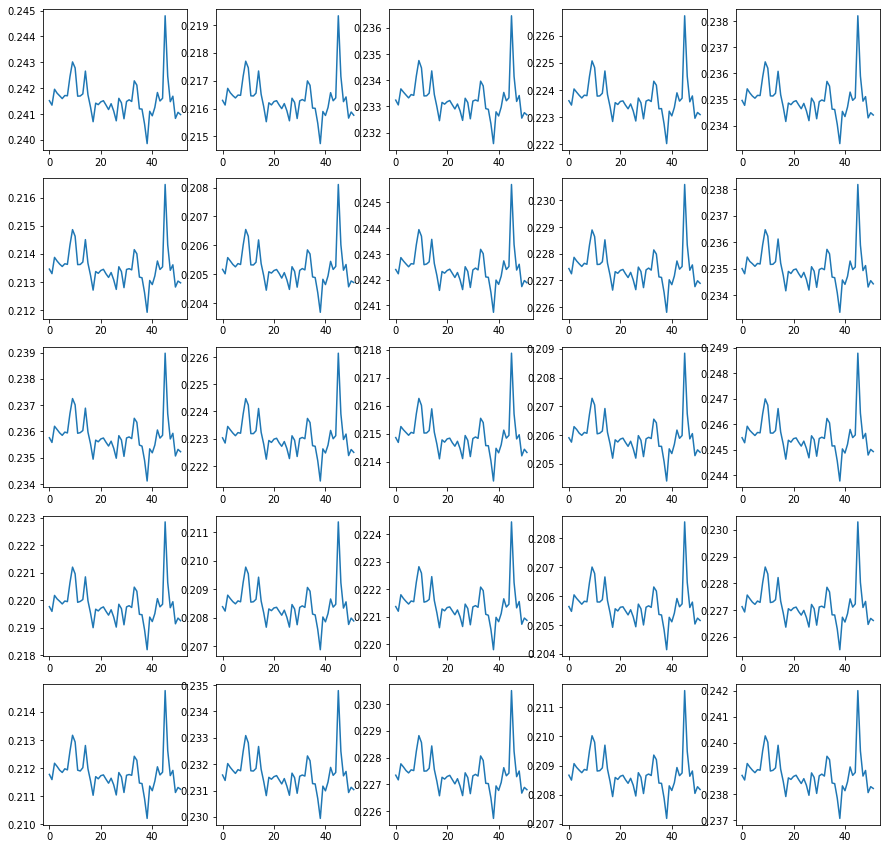

In [24]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
count = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].plot(l21H[:, count])
        count += 1

l21R shape: (52, 22645)


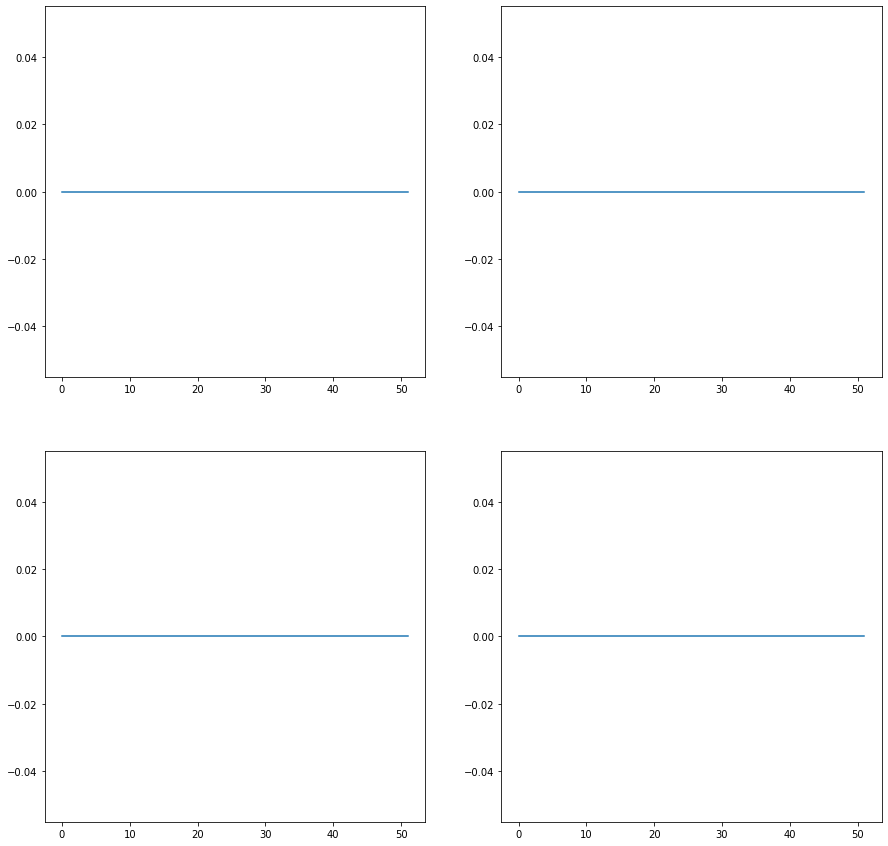

In [17]:
# Reconstruction
print("l21R shape:", l21R.shape)
fig, axs = plt.subplots(2,2,figsize=(15,15))
count = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].plot(l21R[:,count])
        count += 1

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


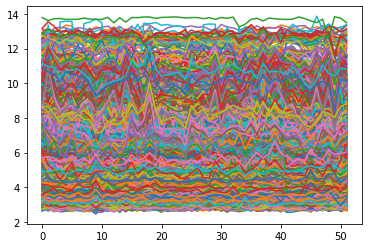

In [14]:
print(L)
plt.clf()
L = X - S
for i in range(S.shape[1]):
    # plt.plot(S[:,i], label = "S val")
    # plt.plot(L[:,i], label = "L val")
    plt.plot(X[:,i], label = "X val")

[[0.00142514 0.00140712 0.00178462 ... 0.00201584 0.00206166 0.00192858]
 [0.00147809 0.00151346 0.00186691 ... 0.00205033 0.00212197 0.00197048]
 [0.00141482 0.00156035 0.00181382 ... 0.00203185 0.00208145 0.00193146]
 ...
 [0.00145683 0.00149467 0.00179818 ... 0.00182816 0.00181853 0.00166579]
 [0.00147678 0.00150171 0.00187019 ... 0.00200875 0.00199467 0.0018713 ]
 [0.00149435 0.00160671 0.00191642 ... 0.00194642 0.00194871 0.00182658]]


<Figure size 432x288 with 0 Axes>

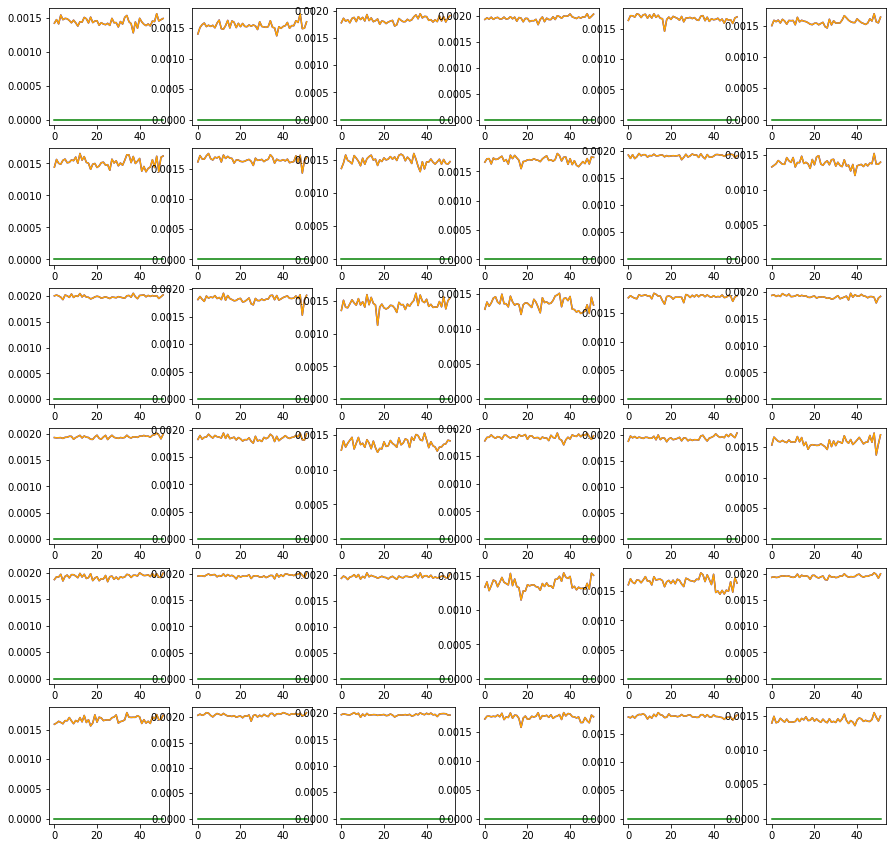

In [50]:
print(L)
plt.clf()
fig, axs = plt.subplots(6,6,figsize=(15,15))
count = 0
L = X - S
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].plot(S[:,count], label = "S val", color='green')
        axs[i,j].plot(L[:,count], label = "L val", color='blue')
        axs[i,j].plot(X[:,count], label = "X val", color='orange')
        count += 1